In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def tank(levels,t,pump,valve):
    h1 = max(0.0,levels[0])
    h2 = max(0.0,levels[1])
    c1 = 0.08 # inlet valve coefficient
    c2 = 0.04 # tank outlet coefficient
    dhdt1 = c1*(1.0-valve)*pump - c2*np.sqrt(h1)
    dhdt2 = c1*valve*pump + c2*np.sqrt(h1)-c2*np.sqrt(h2)
    # overflow conditions
    if h1>1.0 and dhdt1>0.0:
        dhdt1 = 0
    if h2>1.0 and dhdt2>0.0:
        dhdt2 = 0
    dhdt = [dhdt1,dhdt2]
    return dhdt

# initial conditions (levels)
h0 = [0.0,0.0]

# time points to report the solution
tf = 200
t = np.linspace(0,200,tf+1)
# input that can be adjusted
pump = np.zeros((tf+1))
# pump can operate between 0 and 1
pump[10:]=0.2
# valve = 0, directly into top tank
# valve = 1, directly into bottom tank
valve = 0.0
# record the solution
y = np.empty((tf+1,2))
y[0:,]= h0

# simulate the tank step test
for i in range(tf):
    # specify the pump and valve
    inputs = (pump[i],valve)
    # integrate the model
    h = odeint(tank,h0,[0,1],args=inputs)
    y[i+1] = h[-1,:]
    # reset the initial condition
    h0 = h[-1,:]

# Export step test data file
# reshape as column vectors
time_col = t.reshape(-1,1)
pump_col = pump.reshape(-1,1)
h2_col = y[:,1].reshape(-1,1)
my_data = np.concatenate((time_col,pump_col,h2_col), axis=1)
np.savetxt('step_test_data.txt',my_data,delimiter=',')

# Plot results
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(t,y[:,0],'b-',label='height 1')
plt.plot(t,y[:,1],'r--',label='height 2')
plt.ylabel('Height (m)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,pump,'k-',label='pump')
plt.legend(loc='best')
plt.ylabel('Pump')
plt.xlabel('Time (sec)')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# import csv data file
# column 1 = time (t)
# column 2 = input (u)
# column 3 = output (yp)
data = np.loadtxt('step_test_data.txt',delimiter=',')
t = data[:,0]
pump = data[:,1]
h2 = data[:,2]
# initial conditions
u0 = pump[0]
yp0 = h2[0]

# interpolate time with pump
uf = interp1d(t,pump)
# fopdt model
def model(y,t,uf,Km,taum,thetam):
    # arguments
    # y = output
    # t = time
    # uf = input linear function(for time shift)
    # Km = model gain
    # taum = model time constant
    # thetam = model time constant
    # time-shift u
    try:
        if (t-thetam)<0:
            um=uf(0.0)
        else:
            um=uf(t-thetam)
    except:
        #print('Error with time extrapolation: '+str(t))
        um=0
    dydt = (-y + Km*um)/taum
    return dydt
    
# simulate FOPDT model with x = [Km,taum,thetam]
def sim_model(x):
    # input_arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(len(t)) 
    # initial condition
    ym[0] = yp0
    # loop through time steps
    for i in range(0,len(t)-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(model,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1]=y1[-1]
    return ym

def objective(x):
    ym = sim_model(x)
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-h2[i])**2
    return obj
x0 = [0.8,42.06,2.17]
print('Initial SSE Objective: ' + str(objective(x0)))

bnds = ((0.0,1.0e10),(0.0,1.0e10),(0.0,1.0e10))
solution = minimize(objective,x0,method = 'SLSQP',bounds = bnds)
print(solution)
x = solution.x

ym1 = sim_model(x0)
ym2 = sim_model(x)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth = 3,label='Initial Guess')
plt.plot(t,ym2,'k:',linewidth = 3,label='Optimized')
plt.plot(t,h2,'r--',linewidth = 3,label='Tank')
plt.xlabel('Time (sec)')
plt.ylabel('Level')

plt.subplot(2,1,2)
plt.plot(t,pump,'r--',linewidth = 3,label='Pump')
plt.ylabel('Pump')
plt.xlabel('Time (sec)')
plt.show()

Initial SSE Objective: 0.0251103758076
     fun: 0.0021372421128111108
     jac: array([ -7.19042186e-02,   5.41401096e-06,  -1.26759506e+00,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([  8.01986850e-01,   3.28969066e+01,   9.43039431e-08])


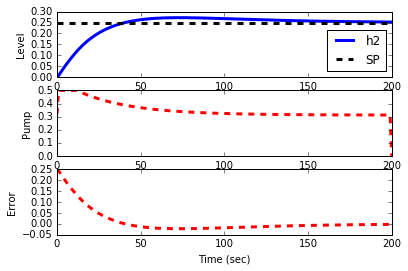

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
%matplotlib inline
# import csv data file
# column 1 = time (t)
# column 2 = input (u)
# column 3 = output (yp)
data = np.loadtxt('step_test_data.txt',delimiter=',')
t = data[:,0]
pump = np.zeros(len(t))
h2 = np.zeros(len(t))
# initial conditions
u0 = pump[0]
yp0 = h2[0]

# fopdt model
def model(y,t,uf,Km,taum,thetam):
    # arguments
    # y = output
    # t = time
    # uf = input linear function(for time shift)
    # Km = model gain
    # taum = model time constant
    # thetam = model time constant
    # time-shift u
    dydt = (-y + Km*uf)/taum
    return dydt

Km = 0.802
taum = 32.897
thetam = 9.43e-8

# IMC PID tuning
tauc = max(1.0*taum,8.0*thetam)
Kc = 1/Km*(taum+0.5*thetam)/(tauc + 0.5*thetam)
# Kc = 2.0
tauI = taum + 0.5*thetam
# tauI = 1.0
# tauD = 0.5
tauD = taum*thetam/(2*taum+thetam)


# storing data
ys = np.zeros(len(t))
ys[0] = yp0
SP = np.ones(len(t))*0.25
e = np.zeros(len(t))
integral = 0.0
derive = 0.0

# Simulate time delay !!!!!!!!!
delta_t = t[1]-t[0]
ndelay = int(np.ceil(thetam / delta_t))

for i in range(len(t)-1):
#     iop = max(0,i-ndelay)
    e[i] = SP[i] - yp0
    integral = integral+ e[i]*delta_t
    if i>=1:
        derive = (ys[i]-ys[i-1])/delta_t
    pump[i] = pump[0]+Kc*e[i] + Kc/tauI*integral - Kc*tauD*derive
    if pump[i]>=0.5:
        pump[i] = 0.5
        integral = integral- e[i]*delta_t
    if pump[i]<=0.2:
        pump[i] = 0.1
        integral = integral- e[i]*delta_t
        
    ts = [t[i],t[i+1]]
    y = odeint(model,yp0,ts,args=(pump[i],Km,taum,thetam))
    ys[i+1] = y[-1]
    yp0 = y[-1]

plt.figure()
plt.subplot(3,1,1)
plt.plot(t,ys,'b-',linewidth = 3,label='h2')
plt.plot([0,t[-1]],[SP[0],SP[0]],'k--',linewidth = 3,label='SP')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.ylabel('Level')

plt.subplot(3,1,2)
plt.plot(t,pump,'r--',linewidth = 3,label='Pump')
plt.ylabel('Pump')
plt.xlabel('Time (sec)')

plt.subplot(3,1,3)
plt.plot(t,e,'r--',linewidth = 3,label='Error')
plt.ylabel('Error')
plt.xlabel('Time (sec)')
plt.show()
